## Segment Piston and FDSP control using a set of Segment Piston Sensors

In [1]:
import sys
import numpy as np
import math
import ceo
import matplotlib.pyplot as plt
import IPython
%matplotlib inline
import scipy.io as sio

In [2]:
## Generic simulation parameters
VISU = True   # show graphic displays

In [3]:
#Compute the rms over each segment
def segment_rms(WF, P):
    rms_seg = np.sqrt(np.sum((WF[np.newaxis,:,np.newaxis]*P)**2,axis=1)/P.sum(axis=1))
    return rms_seg

### Initialization of CEO objects
1) GMT (gmt)

2) on-axis GS for performance evaluation (ongs)

3) AO correction: GS asterism (gs); SH WFS set (wfs)

4) Science Field Performance Evaluation (sfgs)

5) Phasing correction: GS asterism (gsps); Segment Pistons Sensors (ps)

In [4]:
print '----->  Initializing CEO objects....'

# Telescope parameters
D = 25.5
nPx = 14*26+1
# nPx = n*nLenslet + 1
radial_order = 4
n_zern = (radial_order+1)*(radial_order+2)/2
gmt = ceo.GMT_MX(D,nPx,M1_radial_order=radial_order,M2_radial_order=radial_order)

# Initialize on-axis star for performance evaluation
ongs = ceo.Source("I",zenith=0.,azimuth=0., rays_box_size=D,rays_box_sampling=nPx,rays_origin=[0.0,0.0,25])

# number of SH WFS Guide Stars and position
N_GS = 1
if N_GS > 1:
    alpha =6*60.  # radius of circle where GSs are located [in arcsec]
    zenith_angle  = np.ones(N_GS)*alpha*math.pi/180/3600 # in radians
    azimuth_angle = np.arange(N_GS)*360.0/N_GS # in degrees
else:
    alpha = 0.
    zenith_angle = 0.
    azimuth_angle = 0.
    
# GS for SH wavefront sensing
gs = ceo.Source("R",zenith=zenith_angle,azimuth=azimuth_angle*math.pi/180,
                    rays_box_size=D,rays_box_sampling=nPx,rays_origin=[0.0,0.0,25])

# SH WFS parameters
nLenslet = 26  # number of sub-apertures across the pupil
n = 14         # number of pixels per subaperture
detectorRes = 2*n*nLenslet/2
BINNING = 2
wfs = ceo.ShackHartmann(nLenslet, n, D/nLenslet,N_PX_IMAGE=2*n,BIN_IMAGE=BINNING,N_GS=N_GS)

----->  Initializing CEO objects....


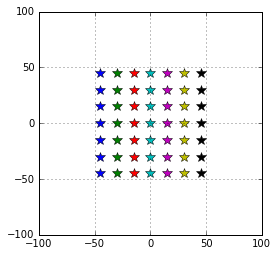

In [5]:
#Initialize asterism for performance evaluation in the science field

#SF_N_GS = 16
#sf_alpha =[15.,30.]  # radius of science field (arcsec)
#SF_N_SEP = len(sf_alpha)
#sf_zenith_angle = np.tile(sf_alpha, SF_N_GS)*math.pi/180/3600 # in radians
#sf_azimuth_angle = np.repeat(np.arange(SF_N_GS)*360.0/SF_N_GS, SF_N_SEP) # in degrees
#sfxx = np.tile(sf_alpha, SF_N_GS) * np.cos(sf_azimuth_angle*math.pi/180)  #in arcsec
#sfyy = np.tile(sf_alpha, SF_N_GS) * np.sin(sf_azimuth_angle*math.pi/180)  #in arcsec

sfx = np.arange(-45.,55.,15.) # in arcsec
sfy = np.arange(-45.,55.,15.) # in arcsec
sfxx, sfyy = np.meshgrid(sfx, sfy)
sf_zenith_angle = np.sqrt(sfxx**2 + sfyy**2) * ceo.constants.ARCSEC2RAD
sf_azimuth_angle = np.arctan2(sfyy,sfxx)

sfgs = ceo.Source("I",zenith=sf_zenith_angle,azimuth=sf_azimuth_angle,#*math.pi/180,
                  rays_box_size=D,rays_box_sampling=nPx,rays_origin=[0.0,0.0,25])

if VISU == True:
    fig,ax1 = plt.subplots()
    fig.set_size_inches((4,4))
    ax1.plot(sfxx,sfyy, '*', markersize=10)
    ax1.set_xlim([-100,100])
    ax1.set_ylim([-100,100])
    ax1.grid()

In [5]:
#Initialize SPS guide stars and sensors
SPStype = 'DFS'  #Choose between "ideal" or "DFS"

N_GS_PS = 3
alpha_ps = 6.0*60.  # radius of circle where GSs are located [in arcsec]
zenith_angle_ps  = np.ones(N_GS_PS)*alpha_ps*math.pi/180/3600 # in radians
azimuth_angle_ps = np.arange(N_GS_PS)*360.0/N_GS_PS # in degrees
gsps = ceo.Source("J",zenith=zenith_angle_ps,azimuth=azimuth_angle_ps*math.pi/180,
                    rays_box_size=D,rays_box_sampling=nPx,rays_origin=[0.0,0.0,25])

In [6]:
if SPStype == 'ideal':
    # Idealized Segment Piston Sensors
    ps = ceo.IdealSegmentPistonSensor(gmt, gsps)
elif SPStype == 'DFS':
    # Dispersed Fringe Sensor
    sps_fov = 3.0 #arcsec diameter
    sps_dispersion = 5.0
    ps = ceo.DispersedFringeSensor(gmt.M1, gsps, dispersion=sps_dispersion, 
                                   field_of_view=sps_fov)#,nyquist_factor=2)
    ps.lobe_detection = 'peak_value'
    throughput = 0.46 * 0.8  #Table 4, FWN74
    ps.camera.photoelectron_gain = throughput
    sps_mask_size = 1.5  #arcsec
    ps.init_detector_mask(sps_mask_size)   

Size of DFS detector mask [pix]: 20


### Initial calibrations (with telescope perfectly phased)
1) AO SH WFS reference slopes

2) SPS reference slopes

3) Field aberrations in the direction of performance GS (ongs, sfgs)

In [7]:
gmt.reset()   # Telescope perfectly phased

pupil sampling: 365 pixel
SH Pixel scale: 0.135arcsec
SH Field of view: 1.884arcsec


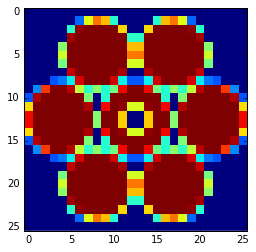

In [8]:
# Calibrate AO SH WFS slope null vector
gs.reset()
gmt.propagate(gs)
wfs.calibrate(gs,0.2)

if VISU == True:
    plt.imshow(wfs.flux.host(shape=(nLenslet*N_GS,nLenslet)).T,interpolation='none')

print "pupil sampling: %d pixel"%nPx
print "SH Pixel scale: %.3farcsec"%(wfs.pixel_scale_arcsec)
sh_fov = wfs.pixel_scale_arcsec*wfs.N_PX_IMAGE/BINNING
print "SH Field of view: %.3farcsec"%(sh_fov)

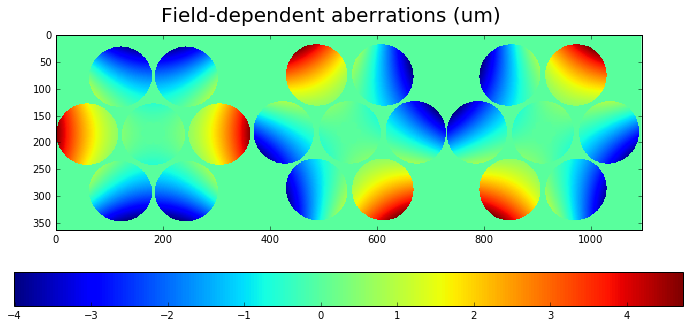

In [9]:
# Calibrate DFS
gsps.reset()
if SPStype == 'DFS':
    ps.calibrate(gsps,gmt)
    ps.reset()
    gsps.reset()

# Calibrate SPS reference vector (corresponding to field-dependent aberrations)
gmt.propagate(gsps)
ph_fda = gsps.phase.host(units='micron').T
SPSmeas_ref = ps.piston(gsps, segment='edge')
#print np.array_str(SPSmeas_ref*1e9, precision=4, suppress_small=True)

# Needed in the projection of off-axis phases onto Zernikes
ph_fda_test = gsps.wavefront.phase.host(units='micron')
amp_fda_test = gsps.wavefront.amplitude.host()

if VISU == True:
    fig, ax = plt.subplots()
    fig.set_size_inches(20,5)
    fig.suptitle('Field-dependent aberrations (um)', fontsize=20)
    imm = ax.imshow(ph_fda, interpolation='None')
    fig.colorbar(imm, orientation='horizontal', shrink=0.6)

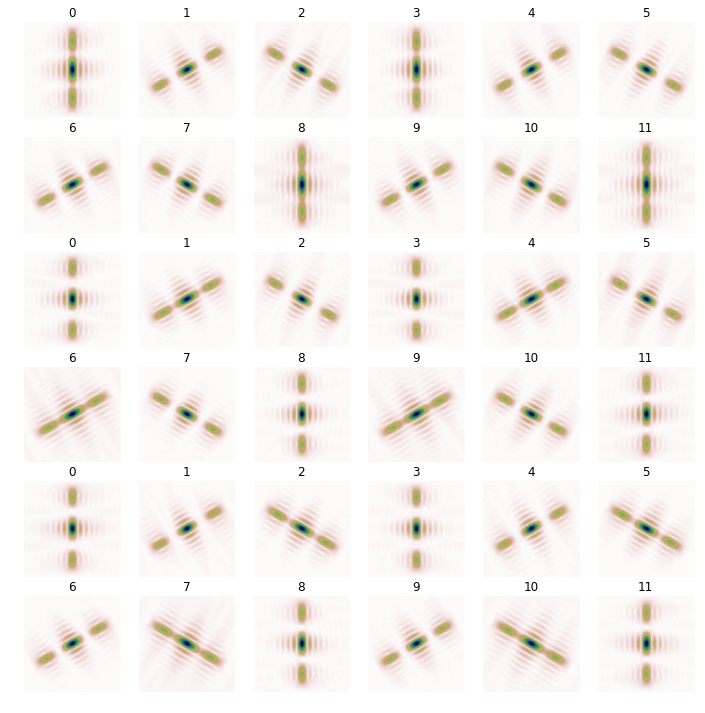

In [10]:
### Show DFS refernce imagettes
def show_sps_imagettes():
    dataCube = ps.get_data_cube(data_type='fftlet')

    fig, ax = plt.subplots(ps.camera.N_SIDE_LENSLET,ps.camera.N_SIDE_LENSLET)
    fig.set_size_inches((12,12))
    xvec = np.arange(0,ps.camera.N_PX_IMAGE,10)
    for k in range(gsps.N_SRC*12):   
        (ax.ravel())[k].imshow(np.sqrt(dataCube[:,:,k]), cmap=plt.cm.gist_earth_r, origin='lower')
        (ax.ravel())[k].autoscale(False)
        if ps.INIT_ALL_ATTRIBUTES == True:
            (ax.ravel())[k].plot(xvec, xvec*ps.pl_m[k] + ps.pl_b[k], 'y')
            (ax.ravel())[k].plot(xvec, xvec*ps.pp_m[k] + ps.pp_b[k], 'y--')
            for pp in range(3):
                c1 = Circle((sps.blob_data[k,pp,1], sps.blob_data[k,pp,0]),radius=np.sqrt(2)*ps.blob_data[k,pp,2], 
                            color='b', fill=False)    
                (ax.ravel())[k].add_patch(c1)
        (ax.ravel())[k].set_title('%d'%(k%12), fontsize=12)

    for k in range(ps.camera.N_SIDE_LENSLET**2):
        (ax.ravel())[k].axis('off')
        
if VISU == True and SPStype == 'DFS':
    show_sps_imagettes()

--> WF RMS on-axis: 0.79 nm wf RMS


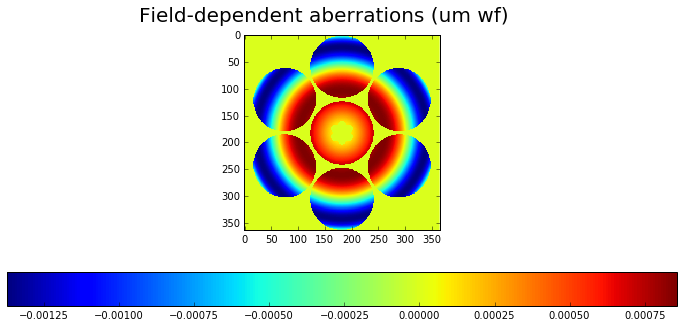

In [11]:
# Field aberrations in the on-axis performance directions (ongs)
ongs.reset()
gmt.propagate(ongs)
ph_fda_on = ongs.phase.host(units='micron')
amp_fda_on = ongs.wavefront.amplitude.host()
Wref = np.rollaxis( ongs.wavefront.phase.host(units='nm', shape=(1,ongs.N_SRC,ongs.n*ongs.m)),1,3)
on_rms0 = ongs.wavefront.rms()*1e9
print '--> WF RMS on-axis: %3.2f nm wf RMS'%on_rms0

if VISU == True:
    fig, ax = plt.subplots()
    fig.set_size_inches(20,5)
    fig.suptitle('Field-dependent aberrations (um wf)', fontsize=20)
    imm = ax.imshow(ph_fda_on, interpolation='None')
    fig.colorbar(imm, orientation='horizontal', shrink=0.6)

--> max WF RMS at the edge of the field: 63.23 nm WF RMS


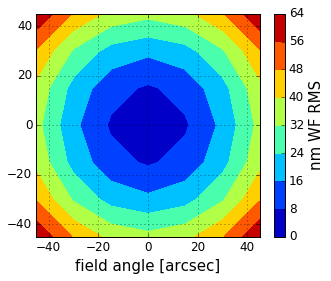

In [13]:
# Field aberrations in the off-axis performance directions (sfgs)
sfgs.reset()
gmt.propagate(sfgs)
sf_rms0 = sfgs.wavefront.rms()*1e9
print '--> max WF RMS at the edge of the field: %3.2f nm WF RMS'%np.max(sf_rms0)

if VISU == True:
    fig, ax2 = plt.subplots()
    fig.set_size_inches((5,4))
    contp = ax2.contourf(sfx, sfy, sf_rms0.reshape(len(sfx),-1))
    clb = fig.colorbar(contp, ax=ax2)
    ax2.grid()
    ax2.tick_params(labelsize=12)
    ax2.set_xlabel('field angle [arcsec]', fontsize=15)
    clb.set_label('nm WF RMS', fontsize=15)
    clb.ax.tick_params(labelsize=12)

### Initialization of on-axis projection of segment shapes onto Zernikes

In [12]:
Zobj = ceo.ZernikeS(radial_order)
Zobj.fitting_init(ongs)

Zernike Inflence Function Matrix:
(133225, 15, 7)


### Interaction and Reconstruction matrices
1) AO SH WFS - M2 segment TT Interaction Matrix and Reconstructor

2) AO SH WFS - M2 segment Zernikes Interaction Matrix and Reconstructor

3) SPS - Segment piston Interaction Matrix and Reconstructor

4) SPS - FDSP Interaction Matrix and Reconstructor

___ M2 ___
Segment #0: 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Segment #1: 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Segment #2: 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Segment #3: 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Segment #4: 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Segment #5: 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Segment #6: 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
------------
AO SH WFS - M2 Segment Zernike IM:
(896, 98)
Condition number: 7.216260


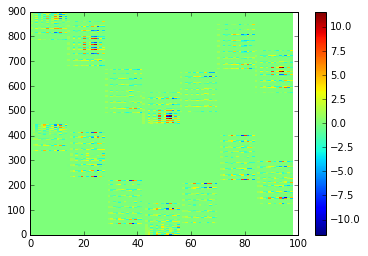

In [13]:
# Calibrate AO SH WFS - M2 segment Zernikes Interaction Matrix
Zstroke = 50e-9 #m rms
first_mode = 1
D_M2_Z = gmt.calibrate(wfs, gs, mirror="M2", mode="zernike", stroke=Zstroke, 
                       first_mode=first_mode)

#remove TT (Z2 & Z3) from IM
#D_M2_Z = ((D_M2_Z.reshape(-1,7,n_zern-1))[:,:,2:]).reshape(-1,(n_zern-3)*7)
nzernall = (D_M2_Z.shape)[1]  ## number of zernike DoFs calibrated
print 'AO SH WFS - M2 Segment Zernike IM:'
print D_M2_Z.shape
print 'Condition number: %f'%np.linalg.cond(D_M2_Z)

if VISU == True:
    plt.pcolor(D_M2_Z)
    plt.colorbar()

A total of 24 leaking SH WFS SAs identified.


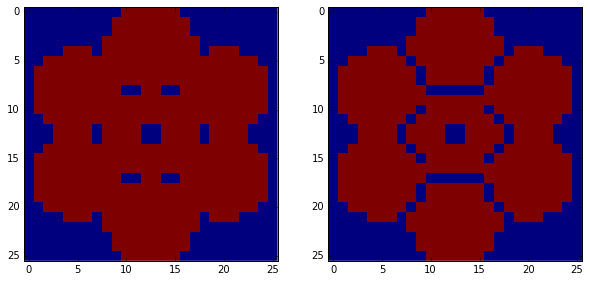

In [14]:
# Identify subapertures belonging to two adjacent segments (leading to control leakage)
QQ = D_M2_Z == 0
LL = np.sum(QQ, axis=1)
LI = np.where( LL[0:wfs.n_valid_lenslet] < (n_zern-1)*6)
print ("A total of %d leaking SH WFS SAs identified."%(LI[0].shape))
vlens = wfs.valid_lenslet.f.host().ravel()
idx = np.where( vlens == 1)
vlens[idx[0][LI]] = 0
leak_slopes_idx = np.array([LI[0], LI[0]+wfs.n_valid_lenslet]).ravel()

if VISU == True:
    fig, (ax1,ax2) = plt.subplots(ncols=2)
    fig.set_size_inches(10,8)
    ax1.imshow(wfs.valid_lenslet.f.host().reshape(nLenslet,nLenslet), interpolation='None')
    ax2.imshow(vlens.reshape(nLenslet,nLenslet),  interpolation='None')

In [15]:
#Remove leaking SAs from AO SH WFS - M2 segment Zernikes:
D_M2_Z[leak_slopes_idx,:] = 0
print 'Condition number: %f'%np.linalg.cond(D_M2_Z)

Condition number: 6.851310


In [16]:
# compute the AO SH WFS - M2 segment Zernikes REC
R_M2_Z = np.linalg.pinv(D_M2_Z)
print 'AO SH WFS - M2 Segment Zernike Rec:'
print R_M2_Z.shape

AO SH WFS - M2 Segment Zernike Rec:
(98, 896)


___ M2 ___
Segment #:1 2 3 4 5 6 7 
------------


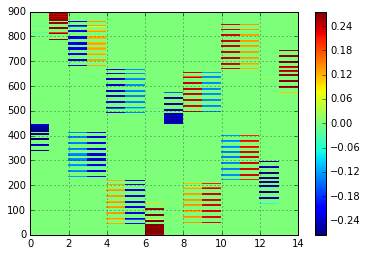

In [17]:
# Calibrate AO SH WFS - M2 segment TT Interaction Matrix and Reconstructor
TTstroke = 50e-3 #arcsec
gmt.reset()
D_M2_TT = gmt.calibrate(wfs, gs, mirror="M2", mode="segment tip-tilt"
                        , stroke=TTstroke*math.pi/180/3600)
if VISU == True:
    fig, ax = plt.subplots()
    fig.set_size_inches(6,4)
    imm = ax.pcolor(D_M2_TT)  
    ax.grid()
#    ax.set_xticklabels(['S1 $T_z$','S2 $T_z$','S3 $T_z$','S4 $T_z$','S5 $T_z$','S6 $T_z$'], 
#                        ha='left', fontsize=15, rotation=45, color='b')
    fig.colorbar(imm)

In [18]:
#Remove leaking SAs from AO SH WFS - M2 segment TT IM:
D_M2_TT[leak_slopes_idx,:] = 0
print 'Condition number: %f'%np.linalg.cond(D_M2_TT)

Condition number: 1.060570


In [19]:
R_M2_TT = np.linalg.pinv(D_M2_TT)
print 'AO SH WFS - M2 segment TT Rec:'
print R_M2_TT.shape

AO SH WFS - M2 segment TT Rec:
(14, 896)


___ M1 ___
Segment #:1 2 3 4 5 6 
------------
SPS - M1 Ideal Segment Piston Rec:
(6, 6)


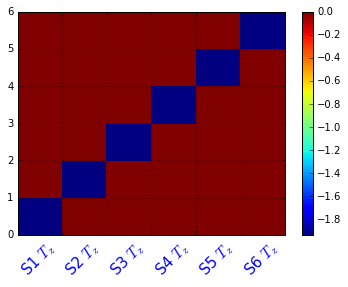

In [27]:
# Calibrate on-axis Ideal Segment Piston Sensor Interaction Matrix and Reconstructor
PSstroke = 200e-9 #m
onps = ceo.IdealSegmentPistonSensor(gmt, gs)
D_M1_PSideal = gmt.calibrate(onps, gs, mirror="M1", mode="segment piston", 
                        stroke=PSstroke, segment='full')

R_M1_PSideal = np.linalg.pinv(D_M1_PSideal)
print 'SPS - M1 Ideal Segment Piston Rec:'
print R_M1_PSideal.shape

gs.reset()
gmt.reset()
gmt.propagate(gs)
onps_signal_ref = onps.piston(gs, segment='full').ravel()[0:6]

if VISU == True:
    fig, ax = plt.subplots()
    fig.set_size_inches(6,4)
    imm = ax.pcolor(D_M1_PSideal)  
    ax.grid()
    ax.set_xticklabels(['S1 $T_z$','S2 $T_z$','S3 $T_z$','S4 $T_z$','S5 $T_z$','S6 $T_z$'], ha='left', 
                       fontsize=15, rotation=45, color='b')
    fig.colorbar(imm)

___ M2 ___
Segment #:1 2 3 4 5 6 
------------


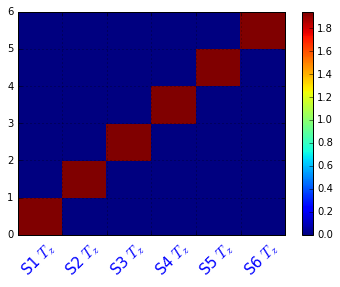

In [29]:
# M2: Calibrate on-axis Ideal Segment Piston Sensor Interaction Matrix and Reconstructor
PSstroke = 200e-9 #m
D_M2_PSideal = gmt.calibrate(onps, gs, mirror="M2", mode="segment piston", 
                        stroke=PSstroke, segment='full')

if VISU == True:
    fig, ax = plt.subplots()
    fig.set_size_inches(6,4)
    imm = ax.pcolor(D_M2_PSideal)  
    ax.grid()
    ax.set_xticklabels(['S1 $T_z$','S2 $T_z$','S3 $T_z$','S4 $T_z$','S5 $T_z$','S6 $T_z$'], ha='left', 
                       fontsize=15, rotation=45, color='b')
    fig.colorbar(imm)

In [32]:
#--- Merge M2 segment TT IM with M2 segment Piston IM

D_PWFS = np.concatenate((D_M2_TT, D_M2_PSideal), axis=0)
print 'Fake PWFS IM Condition number: %f'%np.linalg.cond(D_PWFS)
R_PWFS = np.linalg.pinv(D_PWFS)
print 'Merged SPS - PISTON Rec:'
print R_PWFS.shape

if VISU == True:
    plt.pcolor(D_PWFS)
    plt.colorbar()

ValueError: all the input array dimensions except for the concatenation axis must match exactly

___ M1 ___
Segment #:1 2 3 4 5 6 
------------
SPS - M1 Segment Piston Rec:
(6, 36)


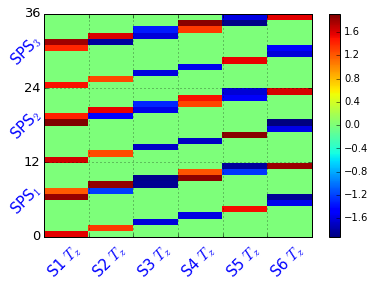

In [21]:
# Calibrate Segment Piston Sensor Interaction Matrix and Reconstructor
PSstroke = 200e-9 #m

D_M1_PS = gmt.calibrate(ps, gsps, mirror="M1", mode="segment piston", 
                        stroke=PSstroke, segment='edge')

"""D_M1_PS = gmt.calibrate(ps, gsps, mirror="M1", mode="segment piston", 
                        stroke=PSstroke, segment='edge', cl_wfs=wfs, cl_gs=gs, cl_recmat=R_M2_Z, 
                       idealps=onps, idealps_rec=R_M1_PSideal, idealps_ref=onps_signal_ref, closed_loop_calib=True)"""

R_M1_PS = np.linalg.pinv(D_M1_PS)
print 'SPS - M1 Segment Piston Rec:'
print R_M1_PS.shape

if VISU == True:
    fig, ax = plt.subplots()
    fig.set_size_inches(6,4)
    imm = ax.pcolor(D_M1_PS*1e-6)  #in displaced pixels per micron
    ax.grid()
    ax.set_ylim([0,36])
    ax.set_xticklabels(['S1 $T_z$','S2 $T_z$','S3 $T_z$','S4 $T_z$','S5 $T_z$','S6 $T_z$'], ha='left'
                       , fontsize=15, rotation=45, color='b')
    ax.set_yticks([0,12,24,36])
    ax.tick_params(axis='y', labelsize=13)
    ax.text(-0.4,6,'SPS$_1$', rotation=45, ha='center', va='center', fontsize=15, color='b')
    ax.text(-0.4,18,'SPS$_2$', rotation=45, ha='center', va='center', fontsize=15, color='b')
    ax.text(-0.4,30,'SPS$_3$', rotation=45, ha='center', va='center', fontsize=15, color='b')
    fig.colorbar(imm)

___ M1 ___
Segment #:1 2 3 4 5 6 
------------
SPS - FDSP Rec:
(12, 36)


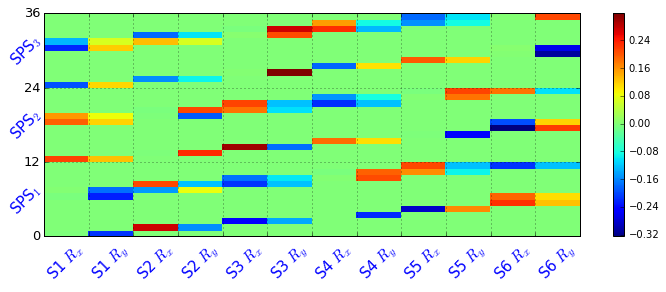

In [22]:
# Calibrate FDSP Interaction Matrix and Reconstructor
TTstroke = 50e-3 #arcsec
gmt.reset()
D_FDSP = gmt.calibrate(ps, gsps, mirror="M1", mode="FDSP", stroke=TTstroke*math.pi/180/3600, 
                       segment='edge', cl_wfs=wfs, cl_gs=gs, cl_recmat=R_M2_TT, CL_calib_modes='TT',
                       idealps=onps, idealps_rec=R_M1_PSideal, idealps_ref=onps_signal_ref, remove_on_pist=True)
R_FDSP = np.linalg.pinv(D_FDSP)
print 'SPS - FDSP Rec:'
print R_FDSP.shape

if VISU == True:
    fig, ax = plt.subplots()
    fig.set_size_inches(12,4)

    #Rx and Ry are in radians. We want to show IM in microns RMS SURF of tilt
    #We found using DOS that a segment tilt of 47 mas is equivalent to 0.5 microns RMS of tilt on an M1 segment.
    AngleRadians_2_tiltcoeff = 0.5 / (47e-3*math.pi/180/3600) #angle in radians to microns RMS of tilt coeff

    imm = ax.pcolor(D_FDSP/AngleRadians_2_tiltcoeff)  #in displaced pixels per microns RMS of M1 segment tilt
    ax.grid()
    ax.set_ylim([0,36])
    ax.set_xticks(range(12))
    ax.set_xticklabels(['S1 $R_x$','S1 $R_y$','S2 $R_x$','S2 $R_y$','S3 $R_x$','S3 $R_y$',
                        'S4 $R_x$','S4 $R_y$','S5 $R_x$','S5 $R_y$','S6 $R_x$','S6 $R_y$'],
                       ha='left', fontsize=15, rotation=45, color='b')
    ax.set_yticks([0,12,24,36])
    ax.tick_params(axis='y', labelsize=13)
    ax.text(-0.4,6,'SPS$_1$', rotation=45, ha='center', va='center', fontsize=15, color='b')
    ax.text(-0.4,18,'SPS$_2$', rotation=45, ha='center', va='center', fontsize=15, color='b')
    ax.text(-0.4,30,'SPS$_3$', rotation=45, ha='center', va='center', fontsize=15, color='b')
    fig.colorbar(imm)

Merged SPS - PISTON Rec:
(18, 36)


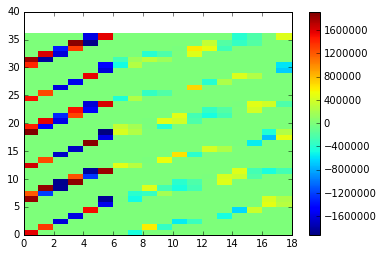

In [23]:
##### Combine Interaction Matrices of M1 segment piston AND FDSP.
D_PIST = np.concatenate((D_M1_PS, D_FDSP), axis=1)
R_PIST = np.linalg.pinv(D_PIST)
print 'Merged SPS - PISTON Rec:'
print R_PIST.shape

if VISU == True:
    plt.pcolor(D_PIST)
    plt.colorbar()

In [24]:
print 'PIST Condition number: %f'%np.linalg.cond(D_M1_PS)
print 'FDSP Condition number: %f'%np.linalg.cond(D_FDSP)
print 'Merged Condition number: %f'%np.linalg.cond(D_PIST)

PIST Condition number: 2.332655
FDSP Condition number: 2.105922
Merged Condition number: 9.306726


### Close loop correction with Brian's FDSP calibrations
The correction comprises:

1) segment tip-tilt
    - sensed with SH WFS
    - corrected on M2 with "fast" loop.

2) FDSP
    - sensed with 3 SPS
    - corrected by applying segment tilts on M1

3) segment piston
    - sensed with 3 SPS
    - corection applied on M1

In [25]:
##### Reset before starting
gs.reset()
gsps.reset()
ongs.reset()
gmt.reset()

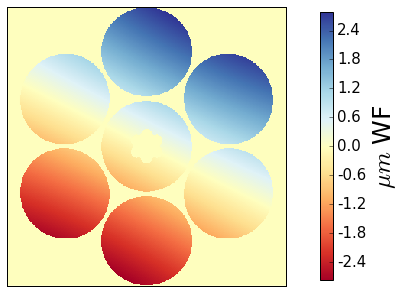

In [98]:
##### Apply a known Tilt to a particular segment on M1
M1RotVecInit = np.array([  #arcsec
            [0,0,0], #[200e-3,0,0] ,
            [0,0,0],
            [0,0,0],
            [0,0,0],
            [0,0,0],
            [0,0,0],
            [0,0,0]]) * math.pi/180/3600   
#M1RotVec = myRotVec
##### Apply a known segment piston/translation to a particular segment on M1
M1TrVecInit = np.array([  # meters surf
            [0,0,0],
            [0,0,0],
            [0,0,0],
            [0,0,0],
            [0,0,0], #500e-9],
            [0,0,0],
            [0,0,0]], dtype='float64')

for idx in range(7): gmt.M1.update(origin=M1TrVecInit[idx,:].tolist(), 
                                   euler_angles=M1RotVecInit[idx,:].tolist(), idx=idx+1)

##### Apply a known Tilt to a particular segment on M2
M2RotVecInit = np.array([  #arcsec
            [0,0,0] ,
            [0,0,0],
            [0,0,0],
            [0,0,0],
            [0,0,0],
            [0,0,0],
            [0,0,0]]) * math.pi/180/3600   

##### Apply a known segment piston/translation to a particular segment on M2
M2TrVecInit = np.array([  # meters surf
            [0,0,0],
            [0,0,0],
            [0,0,0],
            [0,0,0],
            [0,0,0],
            [0,0,0],
            [0,0,0]], dtype='float64')

for idx in range(7): gmt.M2.update(origin=M2TrVecInit[idx,:].tolist(), 
                                   euler_angles=M2RotVecInit[idx,:].tolist(), idx=idx+1)    

"""# Apply a Zernike vector to a particular segment on M1
mysegId = 1
a_M1 = np.zeros(n_zern)   #zernike coeffs, from piston Z1 to n_zern
a_M1[10] = 0.0      # m RMS surf
gmt.M1.zernike.a[mysegId-1,:] = a_M1
#for mmmm in range(6): gmt.M1.zernike.a[mmmm,:] = a_M1
gmt.M1.zernike.update()"""

M2gTTVecInit = np.array((50e-3,-25e-3)) * ceo.constants.ARCSEC2RAD
gmt.M2.global_tiptilt(M2gTTVecInit[0],M2gTTVecInit[1])


if VISU == True:
    gmt.propagate(ongs)
    fig, ax = plt.subplots()
    fig.set_size_inches(20,5)
    imm = ax.imshow(ongs.phase.host(units='micron')-ph_fda_on, interpolation='None',cmap='RdYlBu',origin='lower')#, vmin=-8, vmax=8)
    ax.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
    clb = fig.colorbar(imm, ax=ax, fraction=0.012, pad=0.03,format="%.1f")
    clb.set_label('$\mu m$ WF', fontsize=25)
    clb.ax.tick_params(labelsize=15)
    ongs.reset()

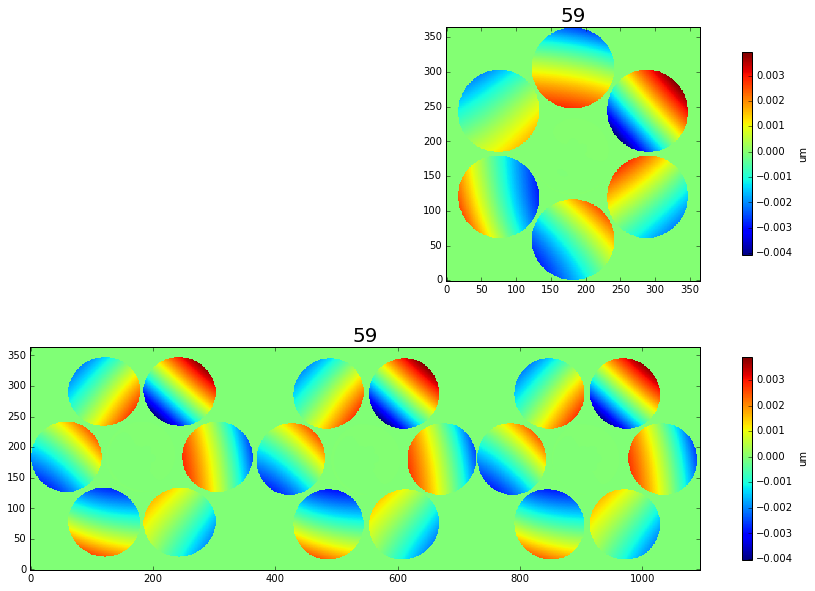

In [99]:
##### Close the loop !!!!!
niter = 10
TTniter = 6
#VISU=False
if VISU == True:
    f, (ax1,ax2) = plt.subplots(2,1)
    f.set_size_inches(15,10)

rmsval = np.zeros(niter*TTniter)
myTTest1 = np.zeros((7,2))
M2TTresiter = np.zeros((7,2,niter*TTniter))
M2gTTiter   =   np.zeros((2,niter*TTniter))
M1TTresiter = np.zeros((7,2,niter*TTniter))
M1PSresiter = np.zeros((7,niter*TTniter))
a_M2 = np.zeros(nzernall)
a_M2_iter = np.zeros((nzernall,niter*TTniter))

M1TrVec  = M1TrVecInit  #np.zeros((7,3))
M1RotVec = M1RotVecInit
M2TrVec  = M2TrVecInit
M2RotVec = M2RotVecInit
M2gTTVec = M2gTTVecInit

gTT = 0.8
gZ  = 0.8
gFDSP = 0.8

for ii in range(niter):
    for jj in range(TTniter):
        ongs.reset()
        gs.reset()
        gmt.propagate(ongs)
        gmt.propagate(gs)
        if VISU == False and jj == TTniter-1:
            gsps.reset()
            gmt.propagate(gsps)
        rmsval[ii*TTniter+jj] = ongs.wavefront.rms()        
        
        #---- visualization
        if VISU == True:
            gsps.reset()
            gmt.propagate(gsps)
            if ii*TTniter+jj > 0: clb.remove()
            h = ax1.imshow(ongs.phase.host(units='micron')-ph_fda_on,interpolation='None', origin='lower')
            ax1.set_title(ii*TTniter+jj, fontsize=20)
            clb = f.colorbar(h, ax=ax1, shrink=0.8)
            clb.set_label('um')
            if ii*TTniter+jj > 0: clb2.remove()
            h2 = ax2.imshow(gsps.phase.host(units='micron').T-ph_fda,interpolation='None', origin='lower')
            ax2.set_title(ii*TTniter+jj, fontsize=20)
            clb2 = f.colorbar(h2, ax=ax2, shrink=0.8)
            clb2.set_label('um')
            IPython.display.clear_output(wait=True)
            IPython.display.display(f)
        
        #---- SH WFS measurement
        wfs.reset()
        wfs.analyze(gs)
        slopevec = wfs.valid_slopes.host().ravel()
        
        #---- segment TT correction
        """myTTest1 = gTT * np.dot(R_M2_TT, slopevec).reshape((7,2))
        M2RotVec[:,0:2] -= myTTest1
        for idx in range(7): gmt.M2.update(origin=M2TrVec[idx,:].tolist(), euler_angles=M2RotVec[idx,:].tolist(), idx=idx+1)"""
        

        #---- Global TT only
        """myTTest1 = gTT * np.dot(R_M2_gTT, slopevec)
        M2gTTVec = -myTTest1
        gmt.M2.global_tiptilt(M2gTTVec[0],M2gTTVec[1])"""
        
        #---- Global TT and Segment TT correction
        myTTest1 = gTT * np.dot(R_M2_TTm, slopevec)
        M2RotVec[:,0:2] -= myTTest1[0:14].reshape((7,2))
        gmt.M2.motion_CS.euler_angles[:,0:2] -= myTTest1[0:14].reshape((7,2))
        gmt.M2.motion_CS.update()
        M2gTTVec = -myTTest1[14:]
        gmt.M2.global_tiptilt(M2gTTVec[0],M2gTTVec[1])
        
        
        M2TTresiter[:,:,ii*TTniter+jj] = M2RotVec[:,0:2]
        M2gTTiter[:,ii*TTniter+jj] = M2gTTVec
        M1TTresiter[:,:,ii*TTniter+jj] = M1RotVec[:,0:2]
        M1PSresiter[:,ii*TTniter+jj] = M1TrVec[:,2]
    
        """#---- segment Zernikes correction (on M2)
        a_M2 += gZ * np.dot(R_M2_Z, slopevec) 
        a_M2_iter[:,ii*TTniter+jj] = a_M2
        atemp = a_M2.reshape((7,-1))
        gmt.M2.zernike.a[:,first_mode:] = -atemp
        gmt.M2.zernike.update()"""

    ##-- FDSP and segment piston correction    
    
    ps.reset()
    PISTmeas = ps.piston(gsps, segment='edge') - SPSmeas_ref
    myPISTest1 = np.dot(R_PIST, PISTmeas.ravel())
    #--- segment piston
    myPSest1 = myPISTest1[0:6]
    print np.array_str(myPSest1*1e9, precision=2, suppress_small=True)
    M1TrVec[0:6,2] -= myPSest1
    #M1TrCor = np.zeros((7,3))
    #M1TrCor[0:6,2] = myPSest1
    #M1TrVec1 = M1TrVec - M1TrCor
    #--- FDSP
    myFDSPest1 = gFDSP * myPISTest1[6:].reshape((6,2))
    M1RotVec[0:6,0:2] -= myFDSPest1
    #M1RotCor = np.zeros((7,3))
    #M1RotCor[0:6,0:2] = myFDSPest1
    #M1RotVec1 = M1RotVec - M1RotCor
    for idx in range(7): gmt.M1.update(origin=M1TrVec[idx,:].tolist(), euler_angles=M1RotVec[idx,:].tolist(), idx=idx+1)
    
      
    """
    ##-- FDSP correction only
    ps.reset()
    FDSPmeas = ps.piston(gs, segment='edge') - SPSmeas_ref
    myFDSPest1 += np.dot(R_FDSP, FDSPmeas.ravel()).reshape((6,2))
    M1RotCor = np.zeros((7,3))
    M1RotCor[0:6,0:2] = myFDSPest1
    M1RotVec1 = M1RotVec - M1RotCor
    for idx in range(7): gmt.M1.update(origin=M1TrVec[idx,:].tolist(), euler_angles=M1RotVec1[idx,:].tolist(), idx=idx+1)
      
    ##-- segment Piston correction only
    ps.reset()
    SPSmeas = ps.piston(gsps, segment='edge') - SPSmeas_ref
    myPSest1 += np.dot(R_M1_PS, SPSmeas.ravel())
    M1TrCor = np.zeros((7,3))
    M1TrCor[0:6,2] = myPSest1
    M1TrVec1 = M1TrVec - M1TrCor
    for idx in range(7): gmt.M1.update(origin=M1TrVec1[idx,:].tolist(), euler_angles=M1RotVec[idx,:].tolist(), idx=idx+1)
    """
ongs.reset()
gsps.reset()
gmt.propagate(ongs)
gmt.propagate(gsps)
Wres = np.rollaxis (ongs.wavefront.phase.host(units='nm', shape=(1,ongs.N_SRC,ongs.n*ongs.m)),1,3)
on_rms = ongs.wavefront.rms()*1e9

#---- visualization
if VISU == True:
    clb.remove()
    h = ax1.imshow(ongs.phase.host(units='micron')-ph_fda_on,interpolation='None', origin='lower')
    clb = f.colorbar(h, ax=ax1, shrink=0.8)
    clb.set_label('um')
    clb2.remove()
    h2 = ax2.imshow(gsps.phase.host(units='micron').T-ph_fda,interpolation='None', origin='lower')
    clb2 = f.colorbar(h2, ax=ax2, shrink=0.8)
    clb2.set_label('um')    
    IPython.display.clear_output(wait=True)
    IPython.display.display(f)
    plt.close()

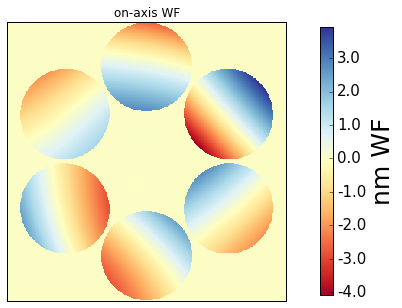

In [100]:
### Show final on-axis residual WF
VISU=True
if VISU == True:
    fig, ax = plt.subplots()
    fig.set_size_inches(20,5)
    imm = ax.imshow(ongs.phase.host(units='nm')-ph_fda_on*1e3, interpolation='None',cmap='RdYlBu', origin='lower')#, vmin=-1.5, vmax=1.5)
    ax.set_title('on-axis WF')
    ax.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
    clb = fig.colorbar(imm, ax=ax, fraction=0.012, pad=0.03,format="%.1f")
    clb.set_label('nm WF', fontsize=25)
    clb.ax.tick_params(labelsize=15)

In [80]:
#### Compute residual WFE in the Field
sfgs.reset()
gmt.propagate(sfgs)
sf_rms = sfgs.wavefront.rms()*1e9

if VISU == True:
    fig,ax = plt.subplots()
    fig.set_size_inches((5,4))
    contp = ax.contourf(sfx, sfy, sf_rms.reshape(len(sfx),-1))
    #contp = ax.imshow(sf_rms.reshape(len(sfx),-1), extent=[-45, 45, -45, 45], origin='lower', interpolation='bilinear')
    clb = fig.colorbar(contp, ax=ax)
    ax.grid()
    ax.tick_params(labelsize=12)
    ax.set_xlabel('field angle [arcsec]', fontsize=15)
    clb.set_label('nm WF RMS', fontsize=15)
    clb.ax.tick_params(labelsize=12)

print '--> WF RMS on-axis: %3.2f nm wf RMS'%on_rms
print '--> max WF RMS at the edge of the field: %3.2f nm WF RMS'%np.max(sf_rms)

NameError: name 'sfgs' is not defined

Final WFE over each segment [microns RMS]:
[[ 1.399  2.031  1.224  1.375  1.379  0.894  0.013]]


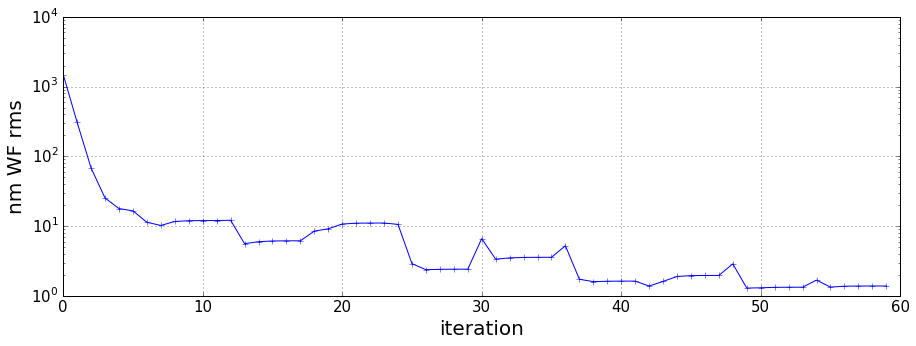

In [101]:
#### on-axis WFE vs. iteration number 
P = np.rollaxis( np.array( ongs.rays.piston_mask ),0,3)

# final wf rms value over each segment
WF = (ongs.phase.host(units='micron')-ph_fda_on).reshape(nPx*nPx)
print 'Final WFE over each segment [microns RMS]:'
print np.array_str(segment_rms(WF,P).T*1e3, precision=3, suppress_small=True)
VISU=True
if VISU == True:
    fig, ax = plt.subplots()
    fig.set_size_inches(15,5)
    ax.semilogy(rmsval*1e9, '-+')
    ax.grid()
    ax.set_xlabel('iteration', fontsize=20)
    ax.set_ylabel('nm WF rms', fontsize=20)
    ax.tick_params(labelsize=15)

Final M1 final piston (Tz) values [nm WF]:
[ 21.91   20.013  -2.153 -21.86  -19.996   2.097   0.   ]
-----
Final M2 final piston (Tz) values [nm WF]:
[ 22.284  20.324  -1.958 -22.28  -20.319   1.963   0.002]


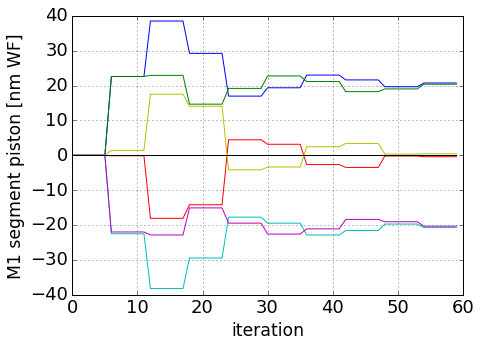

In [102]:
#### Residual segment piston analysis

print 'Final M1 final piston (Tz) values [nm WF]:'
print np.array_str(gmt.M1.motion_CS.origin[:,2]*1e9*2, precision=3, suppress_small=True)
print '-----'
print 'Final M2 final piston (Tz) values [nm WF]:'
print np.array_str(gmt.M2.motion_CS.origin[:,2]*1e9*2, precision=3, suppress_small=True)

if VISU == True:
    f1, ax1 = plt.subplots()
    f1.set_size_inches(7,5)
    ax1.plot(M1PSresiter.T *1e9*2, label='S')
    ax1.grid()
    #ax1.set_title('Tz', size='x-large')
    ax1.set_xlabel('iteration', size='xx-large')
    ax1.set_ylabel('M1 segment piston [nm WF]', size='xx-large')
    ax1.tick_params(labelsize=18)
    #ax1.legend()
    """    initpos = 11
    deltapos = 2
    plt.text(initpos,11,'S1', color='b', ha='center', fontsize=18)
    plt.text(initpos+deltapos,11,'S2', color='g', ha='center', fontsize=18)
    plt.text(initpos+2*deltapos,11,'S3', color='r', ha='center', fontsize=18)
    plt.text(initpos+3*deltapos,11,'S4', color='c', ha='center', fontsize=18)
    plt.text(initpos+4*deltapos,11,'S5', color='m', ha='center', fontsize=18)
    plt.text(initpos+5*deltapos,11,'S6', color='y', ha='center', fontsize=18)
    plt.text(initpos+6*deltapos,11,'S7', color='k', ha='center', fontsize=18)"""


------
Final M2 final TT (Rx, Ry) values [mas]:
[-2.881 -1.886  0.128  2.467  2.829 -0.18  -2.728]
[ 1.414 -1.611 -2.89  -1.056  1.363  2.945  1.297]
------
Final M1 final TT (Rx, Ry) values [mas]:
[ 0.019 -0.051  0.046  0.04   0.004  0.047  0.   ]
[ 0.007 -0.015 -0.017 -0.026 -0.017 -0.015  0.   ]


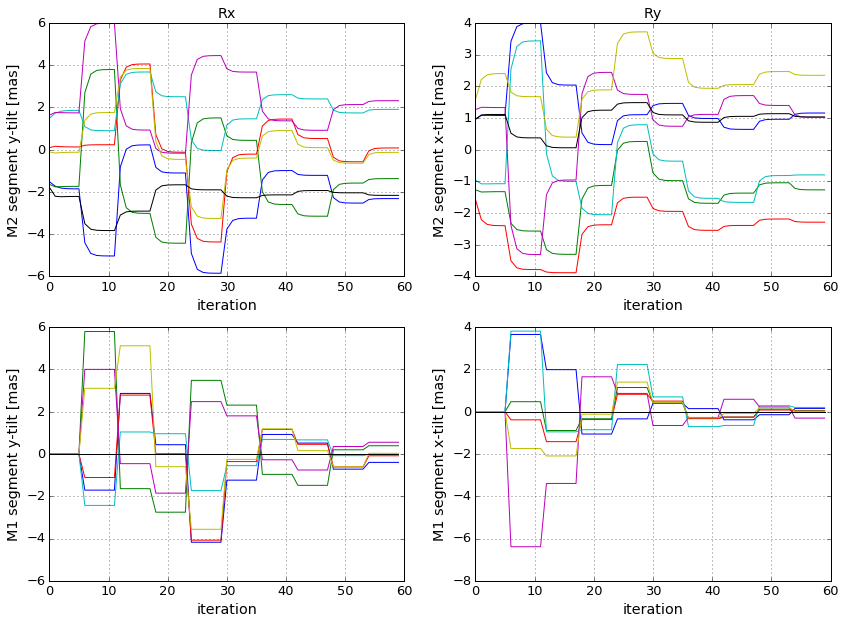

In [103]:
#### Residual M1 / M2 segment Tip-tilt analysis

print '------'
print 'Final M2 final TT (Rx, Ry) values [mas]:'
print np.array_str(gmt.M2.motion_CS.euler_angles[:,0]*ceo.constants.RAD2MAS, precision=3, suppress_small=True)
print np.array_str(gmt.M2.motion_CS.euler_angles[:,1]*ceo.constants.RAD2MAS, precision=3, suppress_small=True)
print '------'
print 'Final M1 final TT (Rx, Ry) values [mas]:'
print np.array_str(gmt.M1.motion_CS.euler_angles[:,0]*ceo.constants.RAD2MAS, precision=3, suppress_small=True)
print np.array_str(gmt.M1.motion_CS.euler_angles[:,1]*ceo.constants.RAD2MAS, precision=3, suppress_small=True)

if VISU == True:
    f1, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2)
    ax1.axis('auto')
    ax2.axis('auto')
    ax3.axis('auto')
    ax4.axis('auto')
    f1.set_size_inches(14,10)

    ax1.plot(M2TTresiter[:,0,:].T * ceo.constants.RAD2MAS)
    ax1.grid()
    ax1.set_title('Rx', size='x-large')
    ax1.set_xlabel('iteration', size='x-large')
    ax1.set_ylabel('M2 segment y-tilt [mas]', size='x-large')
    ax1.tick_params(labelsize=13)

    ax2.plot(M2TTresiter[:,1,:].T *ceo.constants.RAD2MAS)
    ax2.grid()
    ax2.set_title('Ry', size='x-large')
    ax2.set_xlabel('iteration', size='x-large')
    ax2.set_ylabel('M2 segment x-tilt [mas]', size='x-large')
    ax2.tick_params(labelsize=13)

    ax3.plot(M1TTresiter[:,0,:].T *ceo.constants.RAD2MAS*8)
    ax3.grid()
    #ax3.set_title('Rx', size='x-large')
    ax3.set_xlabel('iteration',size='x-large')
    ax3.set_ylabel('M1 segment y-tilt [mas]', size='x-large')
    ax3.tick_params(labelsize=13)

    ax4.plot(M1TTresiter[:,1,:].T *ceo.constants.RAD2MAS*8)
    ax4.grid()
    #ax4.set_title('Ry', size='x-large')
    ax4.set_xlabel('iteration', size='x-large')
    ax4.set_ylabel('M1 segment x-tilt [mas]', size='x-large')
    ax4.tick_params(labelsize=13)

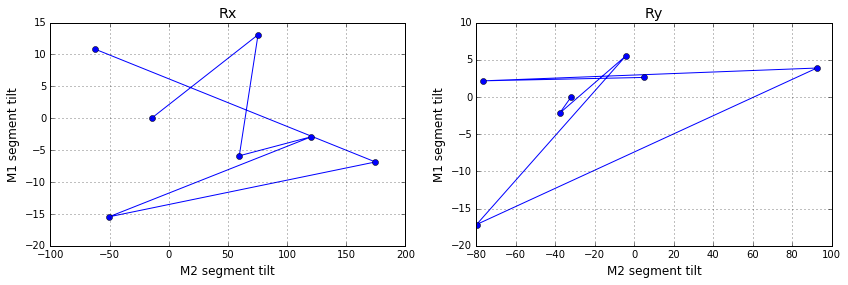

In [84]:
#### M1/M2 segment tilt correlation 
#### Basically, if points lie on a line it means M1 and M2 tilts are compensating each other.
if VISU == True:
    f1, (ax1,ax2) = plt.subplots(1,2)
    f1.set_size_inches(14,4)

    ax1.plot(gmt.M2.motion_CS.euler_angles[:,0]*ceo.constants.RAD2MAS,
         gmt.M1.motion_CS.euler_angles[:,0]*ceo.constants.RAD2MAS, '-o')
    ax1.grid()
    ax1.set_title('Rx', size='x-large')
    ax1.set_xlabel('M2 segment tilt', size='large')
    ax1.set_ylabel('M1 segment tilt', size='large')
    ax2.plot(gmt.M2.motion_CS.euler_angles[:,1]*ceo.constants.RAD2MAS,
         gmt.M1.motion_CS.euler_angles[:,1]*ceo.constants.RAD2MAS, '-o')
    ax2.grid()
    ax2.set_title('Ry', size='x-large')
    ax2.set_xlabel('M2 segment tilt', size='large')
    ax2.set_ylabel('M1 segment tilt', size='large')

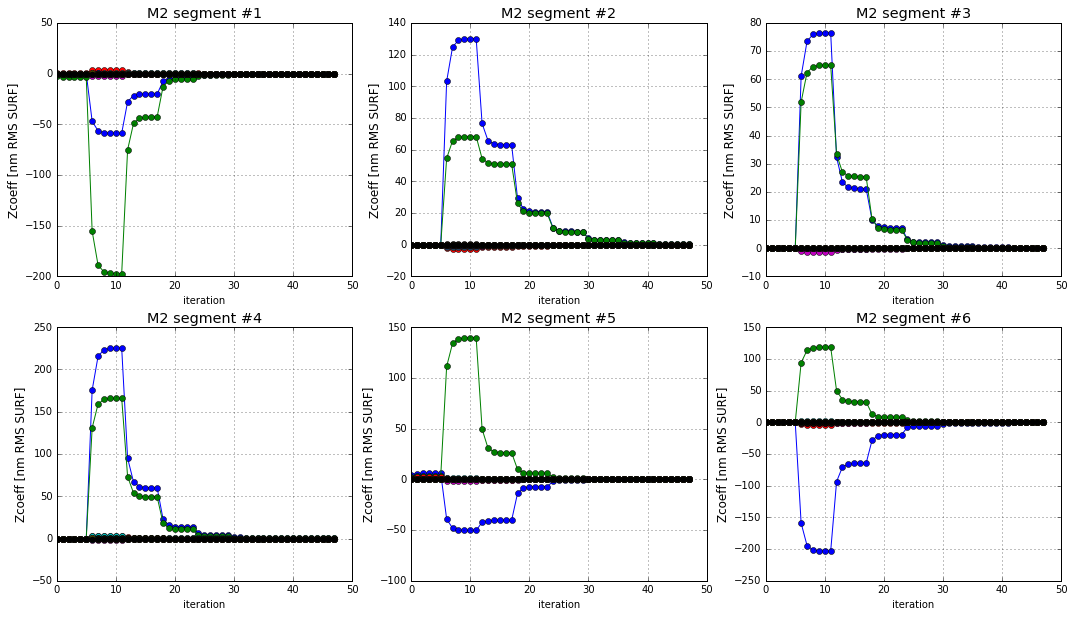

In [54]:
#### Residual M2 segment Zernikes
if VISU == True:
    f1, ax = plt.subplots(ncols=3, nrows=2)
    f1.set_size_inches(18,10)
    for jj in range(6):
        my_a_M2 = (a_M2_iter.reshape((7,-1,niter*TTniter)))[jj,:,:]
        thisax = (ax.ravel())[jj]
        thisax.plot(my_a_M2.T*1e9, '-o')
        thisax.grid()
        thisax.set_title('M2 segment #%d'%(jj+1), size='x-large')
        thisax.set_xlabel('iteration')
        thisax.set_ylabel('Zcoeff [nm RMS SURF]', size='large')

In [ ]:
#Project final residual WF onto segment Zernike modes
arec = np.zeros((Zobj.n_mode, 7))
for segId in range(1,8):
    arec[:,segId-1] = np.dot(invZmat[:,:,segId-1], (Wres-Wref)[:,:,alphaId].reshape(-1))

print 'Zernike Coeffs (Z1 onwards):'
print '============================'
for segId in range(1,8):
    print 'segment #%d: -----------'%segId
    print np.array_str(arec[:,segId-1],precision=3,suppress_small=True)

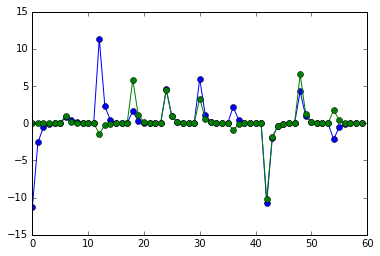

In [93]:
plt.plot(M2gTTiter.T*ceo.constants.RAD2MAS, 'o-')